In [1]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import scipy as sp
import sklearn
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from IPython.display import clear_output
import powerlaw
import tensorflow_addons as tfa
import copy
import weightwatcher as ww
import imageio
from datetime import datetime
import io
import cv2
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import random
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("weightwatcher")
logger.setLevel(logging.CRITICAL)

In [3]:
# Model / data parameters
num_classes = 10
inputShape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# shuffle training set and its labels accordingly
trainingIndexes = np.arange(0,y_train.shape[0]).tolist()
random.shuffle(trainingIndexes)
x_train = x_train[trainingIndexes,:,:,:]
y_train = y_train[trainingIndexes,:]

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# LENET model
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=inputShape),
        layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'),
        layers.MaxPool2D(strides=2),
        layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'),
        layers.MaxPool2D(strides=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ]
)
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               307456    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                2

In [5]:
# define a function which returns an image as numpy array from figure
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [6]:
trainingSize = 2000
testSize = 10000
batch_size = 128
epochs = 30
learningRate = .001
selectComponentsMethod = "randomize_percentage" #"localization_ratio" #"percentage" #"classic" #"percentage" #"powerlaw_spikes" #"mp_spikes" #"powerlaw_xmin"
percentageKept = 40

In [7]:
# updatable plot
# a minimal example (sort of)
 
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.test_losses = []
        self.estimatedLosses = []
        
        self.logs = []

        now = datetime.now()
        date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
        self.writer = imageio.get_writer("training-" + date_time + ".mp4", format = "FFMPEG", mode='I', fps = 1)
 
    def on_epoch_end(self, epoch, logs={}):
        
        clear_output(wait=True)
        
        if selectComponentsMethod == "powerlaw_xmin" or selectComponentsMethod == "powerlaw_spikes":
            self.fig, self.axes = plt.subplots(2,3,figsize=(25,10)) 
        elif selectComponentsMethod == "mp_spikes":
            self.fig, self.axes = plt.subplots(2,3,figsize=(25,10)) 
        elif selectComponentsMethod == "localization_ratio":
            self.fig, self.axes = plt.subplots(1,4, figsize=(30,10))
        elif selectComponentsMethod == "percentage" or selectComponentsMethod == "randomize_percentage":
            self.fig, self.axes = plt.subplots(1,4, figsize=(30,10))

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.test_losses.append(model.evaluate(x_test[0:testSize], y_test[0:testSize], verbose=0)[0])
                
        # careful! Python is dangerous :) as opposed to MATLAB, it can modify the contents of an object from inside a function even if that wasn't asked for.
        # so before we begin, do a deep copy (keras clone) of the model and work with that
        modelToSmooth = keras.models.clone_model(model)
        modelToSmooth.build(model.input_shape) 
        modelToSmooth.compile(loss=model.loss, optimizer=model.optimizer, metrics=["accuracy"])
        modelToSmooth.set_weights(model.get_weights())

        watcher = ww.WeightWatcher(model=modelToSmooth)

        if selectComponentsMethod == "powerlaw_xmin" or selectComponentsMethod == "powerlaw_spikes":
            resultFunction = watcher.unifiedSVDSmoothing(methodSelectComponents = selectComponentsMethod, doPlot = True, axes = [self.axes[0,1],self.axes[0,2],self.axes[1,0],self.axes[1,1]])
        elif selectComponentsMethod == "mp_spikes":
            resultFunction = watcher.unifiedSVDSmoothing(methodSelectComponents = selectComponentsMethod, doPlot = True, axes = [self.axes[0,1],self.axes[0,2],self.axes[1,0],self.axes[1,1]])
        elif selectComponentsMethod == "localization_ratio":
            resultFunction = watcher.unifiedSVDSmoothing(methodSelectComponents = selectComponentsMethod, doPlot = True, axes = [self.axes[1],self.axes[2],self.axes[3]]) #, smoothBias = False, normalizeVectors = False)
        elif selectComponentsMethod == "percentage" or selectComponentsMethod == "randomize_percentage":
            resultFunction = watcher.unifiedSVDSmoothing(methodSelectComponents = selectComponentsMethod, percent = percentageKept / 100, doPlot = True, axes = [self.axes[1],self.axes[2],self.axes[3]])

        self.estimatedLosses.append(resultFunction[0].evaluate(x_train[0:100], y_train[0:100], verbose=0)[0])
     
        self.i += 1
                        
        if selectComponentsMethod == "powerlaw_xmin" or selectComponentsMethod == "powerlaw_spikes":
            self.axes[0,0].plot(self.x, self.losses, label="loss")
            self.axes[0,0].plot(self.x, self.test_losses, label="test_loss")
            self.axes[0,0].plot(self.x, self.estimatedLosses, label="SVDestimate_" + str(resultFunction[1]) + "c")
            self.axes[0,0].title.set_text("Epoch " + str(epoch) + ", training size N" + str(trainingSize) + ", test size N" + str(testSize) + ", using " + selectComponentsMethod) #, fontdict=None, loc='center')
            self.axes[0,0].legend()
        elif selectComponentsMethod == "mp_spikes":
            self.axes[0,0].plot(self.x, self.losses, label="loss")
            self.axes[0,0].plot(self.x, self.test_losses, label="test_loss")
            self.axes[0,0].plot(self.x, self.estimatedLosses, label="SVDestimate_" + str(resultFunction[1]) + "c")
            self.axes[0,0].title.set_text("Epoch " + str(epoch) + ", training size N" + str(trainingSize) + ", test size N" + str(testSize) + ", using " + selectComponentsMethod) #, fontdict=None, loc='center')
            self.axes[0,0].legend()
        elif selectComponentsMethod == "localization_ratio":
            self.axes[0].plot(self.x, self.losses, label="loss")
            self.axes[0].plot(self.x, self.test_losses, label="test_loss")
            self.axes[0].plot(self.x, self.estimatedLosses, label="SVDestimate_" + str(resultFunction[1]) + "c")
            self.axes[0].title.set_text("Epoch " + str(epoch) + ", training size N" + str(trainingSize) + ", test size N" + str(testSize) + ", using " + selectComponentsMethod) #, fontdict=None, loc='center')
            self.axes[0].legend()
        elif selectComponentsMethod == "percentage" or selectComponentsMethod == "randomize_percentage":
            self.axes[0].plot(self.x, self.losses, label="loss")
            self.axes[0].plot(self.x, self.test_losses, label="test_loss")
            self.axes[0].plot(self.x, self.estimatedLosses, label="SVDestimate_" + str(resultFunction[1]) + "c")
            self.axes[0].title.set_text("Epoch " + str(epoch) + ", training size N" + str(trainingSize) + ", test size N" + str(testSize) + ", using " + selectComponentsMethod) #, fontdict=None, loc='center')
            self.axes[0].legend()
        
        plt.show()

        data = get_img_from_fig(self.fig)
        self.writer.append_data(data)

    def on_train_end(self, epoch, logs={}):
      self.writer.close()
        
plot_losses = PlotLosses()

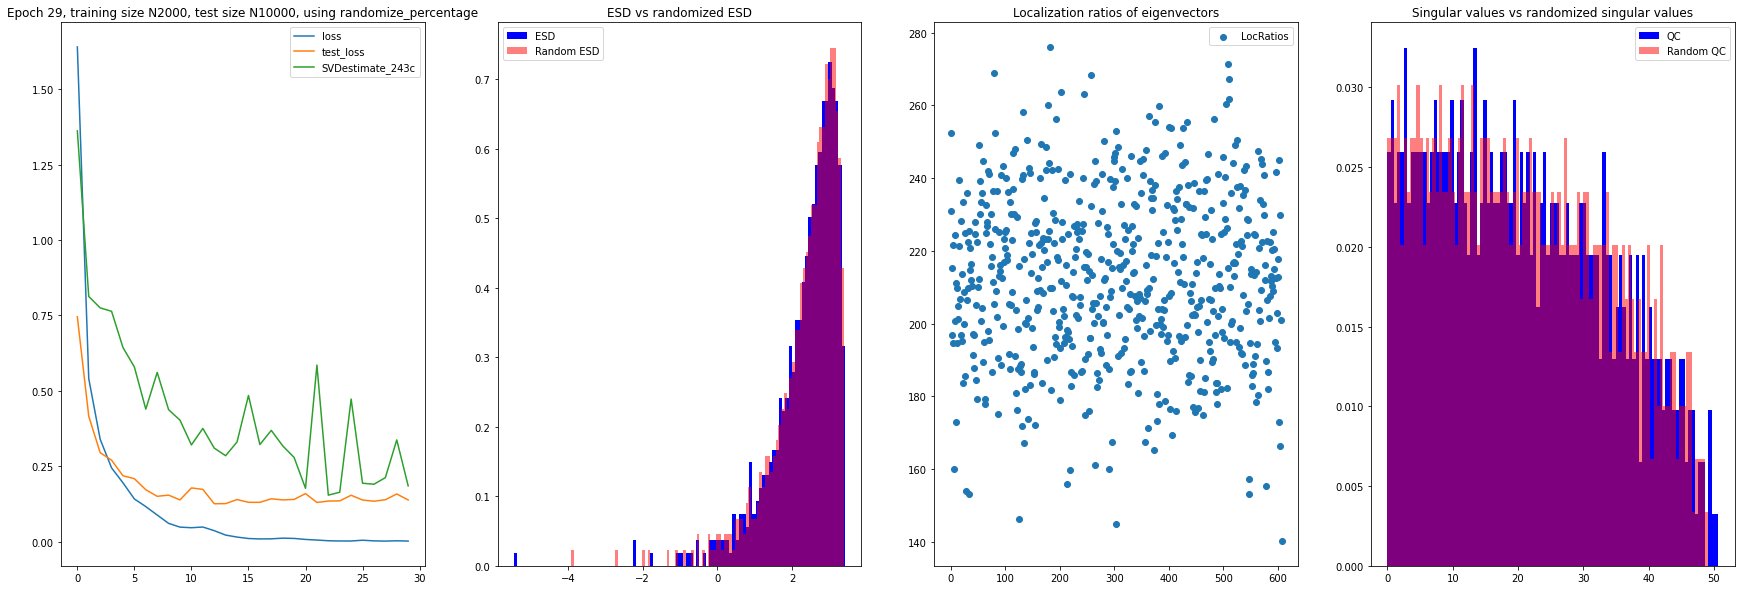

In [8]:
opt = keras.optimizers.Adam(learning_rate=learningRate)
 
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
 
model.fit(x_train[0:trainingSize], y_train[0:trainingSize], batch_size=batch_size, epochs=epochs, validation_split=0, callbacks=[plot_losses])